# 1. Getting VizDoom Up and Running

In [2]:
# Import vizdoom for game env
from vizdoom import *
# Import random for action sampling
import random
# Import time for sleeping
import time
# Import numpy for identity matrix
import numpy as np

In [3]:
# Setup game
game = DoomGame()
game.load_config('GitHub/VizDoom/scenarios/deadly_corridor_S5.cfg')
game.init()

In [4]:
# This is the set of actions we can take in the environment
actions = np.identity(7, dtype = np.uint8)

In [5]:
random.choice(actions)

array([1, 0, 0, 0, 0, 0, 0], dtype=uint8)

In [6]:
game.get_state().screen_buffer.shape

(3, 240, 320)

In [7]:
# Loop through episodes
episodes = 10
for episode in range(episodes):
    # Create a new episode or a game
    game.new_episode()
    # Check the game isn't done
    while not game.is_episode_finished():
        # Get the game state
        state = game.get_state()
        # Get the game image
        img = state.screen_buffer
        # Get the game variables - ammo
        info = state.game_variables
        # Take an action
        reward = game.make_action(random.choice(actions), 4)
        # Print reward
        # print('reward: ', reward)
        time.sleep(0.02)
    print('Result: ', game.get_total_reward())
    time.sleep(2)
game.close()

Result:  -64.99070739746094
Result:  -115.19700622558594
Result:  -99.16317749023438
Result:  -88.16043090820312
Result:  -107.09066772460938
Result:  -66.86360168457031
Result:  -76.01251220703125
Result:  -114.42189025878906
Result:  -51.785064697265625
Result:  -115.9755859375


# 2. Converting it to a Gym Environment

In [8]:
# Import environment base class from OpenAI Gym
from gym import Env
# Import gym spaces
from gym.spaces import Discrete, Box
# Import opencv
import cv2
# Import Environment checker
from stable_baselines3.common import env_checker

In [9]:
Box(low = 0, high = 255, shape = (100, 160, 1), dtype = np.uint8).sample()

array([[[113],
        [110],
        [196],
        ...,
        [ 92],
        [ 87],
        [238]],

       [[182],
        [134],
        [252],
        ...,
        [ 79],
        [ 44],
        [185]],

       [[ 74],
        [119],
        [248],
        ...,
        [ 90],
        [225],
        [ 30]],

       ...,

       [[178],
        [ 75],
        [110],
        ...,
        [ 98],
        [201],
        [ 85]],

       [[145],
        [116],
        [223],
        ...,
        [ 86],
        [231],
        [162]],

       [[146],
        [ 70],
        [223],
        ...,
        [208],
        [ 19],
        [120]]], dtype=uint8)

In [10]:
Discrete(3).sample()

2

In [11]:
actions[Discrete(3).sample()]

array([0, 1, 0, 0, 0, 0, 0], dtype=uint8)

In [12]:
# Create VizDoom OpenAI Gym Environment
class VizDoomGym(Env):
    # Function that is called when we start the env
    def __init__(self, render = False, config = 'GitHub/VizDoom/scenarios/deadly_corridor_S1.cfg'):
        # Inherit from Env
        super().__init__()
        # Setup the game
        self.game = DoomGame()
        self.game.load_config(config)

        # Render frame logic
        if render == False:
            self.game.set_window_visible(False)
        else:
            self.game.set_window_visible(True)
        
        # Start the game
        self.game.init()

        # Create the observation space and the action space
        self.observation_space = Box(low = 0, high = 255, shape = (100, 160, 1), dtype = np.uint8)
        self.action_space = Discrete(7)

        # Game variables : HEALTH DAMAGE_TAKEN HITCOUNT SELECTED_WEAPON_AMMO
        self.damage_taken = 0
        self.hitcount = 0
        self.ammo = 52

    # This is how we take a step in the environment
    def step(self, action):
        # Specify action and take step
        actions = np.identity(7, dtype = np.uint8)
        movement_reward = self.game.make_action(actions[action], 4)

        reward = 0

        # Get all the other stuff we need to return
        if self.game.get_state():
            state = self.game.get_state().screen_buffer
            state = self.grayscale(state)

            # Reward shaping
            game_variables = self.game.get_state().game_variables
            health, damage_taken, hitcount, ammo = game_variables

            # Calculate reward deltas
            damage_taken_deta = -damage_taken + self.damage_taken
            self.damage_taken = damage_taken
            hitcount_delta = hitcount - self.hitcount
            self.hitcount = hitcount
            ammo_delta = ammo - self.ammo
            self.ammo = ammo
            
            reward = movement_reward + damage_taken_deta*10 + hitcount_delta*200 + ammo_delta*5

            info = ammo
        else:
            state = np.zeros(self.observation_space.shape)
            info = 0

        info = {"info":info}
        done = self.game.is_episode_finished()

        return state, reward, done, info
    
    # Define how to render the game or environment
    def render():
        pass
    # What happens when we start a new game
    def reset(self):
        self.game.new_episode()
        state = self.game.get_state().screen_buffer
        return self.grayscale(state)
    
    # Grayscale the game frame and resize it
    def grayscale(self, observation):
        gray = cv2.cvtColor(np.moveaxis(observation, 0, -1), cv2.COLOR_BGR2GRAY)
        resize = cv2.resize(gray, (160, 100), interpolation = cv2.INTER_CUBIC)
        state = np.reshape(resize, (100, 160, 1))
        return state
    
    # Call to close down the game
    def close(self):
        self.game.close()

In [13]:
env = VizDoomGym(render = True)

In [14]:
env.observation_space.sample().shape

(100, 160, 1)

In [15]:
state = env.reset()

In [16]:
state.shape

(100, 160, 1)

In [17]:
state

array([[[32],
        [33],
        [25],
        ...,
        [27],
        [23],
        [24]],

       [[27],
        [33],
        [23],
        ...,
        [24],
        [24],
        [24]],

       [[20],
        [35],
        [23],
        ...,
        [24],
        [24],
        [24]],

       ...,

       [[75],
        [63],
        [62],
        ...,
        [44],
        [71],
        [60]],

       [[15],
        [48],
        [47],
        ...,
        [49],
        [69],
        [47]],

       [[22],
        [14],
        [26],
        ...,
        [57],
        [37],
        [39]]], dtype=uint8)

In [18]:
env.step(2)

(array([[[32],
         [33],
         [25],
         ...,
         [27],
         [23],
         [24]],
 
        [[27],
         [33],
         [23],
         ...,
         [24],
         [24],
         [24]],
 
        [[20],
         [35],
         [23],
         ...,
         [24],
         [24],
         [24]],
 
        ...,
 
        [[75],
         [63],
         [62],
         ...,
         [44],
         [71],
         [60]],
 
        [[15],
         [48],
         [47],
         ...,
         [49],
         [69],
         [47]],
 
        [[22],
         [14],
         [26],
         ...,
         [57],
         [37],
         [39]]], dtype=uint8),
 0.0,
 False,
 {'info': 52.0})

In [19]:
env_checker.check_env(env)

# 3. View Game State

In [20]:
# Import matplotlib for visualization
from matplotlib import pyplot as plt

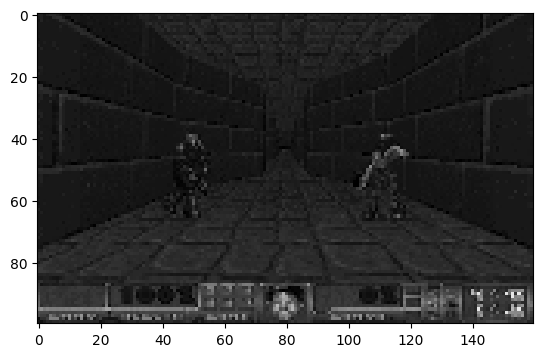

In [21]:
plt.imshow(cv2.cvtColor(state, cv2.COLOR_BGR2RGB))

In [22]:
env.close()

# 4. Setup Callback

In [23]:
# Import os for file nav
import os
# Import callback class from sb3
from stable_baselines3.common.callbacks import BaseCallback

In [24]:
class TrainAndLoggingCallback(BaseCallback):

    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)

        return True

In [25]:
CHECKPOINT_DIR = './train/train_corridor'
LOG_DIR = './logs/log_corridor'

In [26]:

callback = TrainAndLoggingCallback(check_freq = 10000, save_path = CHECKPOINT_DIR)

# 5. Hyperparameter Optimization

In [89]:
# Non rendered environment
env = VizDoomGym(config = "GitHub/VizDoom/scenarios/deadly_corridor_S1.cfg")

In [90]:
import optuna
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import CheckpointCallback
import numpy as np
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv, VecTransposeImage

def evaluate_model(model, eval_env, n_eval_episodes=10):
    """
    Evaluate the trained RL model.

    Parameters:
    - model: The trained reinforcement learning model.
    - eval_env: The evaluation environment.
    - n_eval_episodes: Number of episodes to use for evaluation.

    Returns:
    - mean_reward: Mean reward obtained over the evaluation episodes.
    """
    mean_reward, _ = evaluate_policy(model, eval_env, n_eval_episodes=n_eval_episodes)
    return mean_reward


# Define the evaluation environment
eval_env = DummyVecEnv([lambda: Monitor(env, './logs/eval')])

# Define PPO training function
def objective(trial):
    # Define hyperparameters to search
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
    n_steps = trial.suggest_int('n_steps', 128, 2048)
    clip_range = trial.suggest_uniform('clip_range', 0.1, 0.4)
    gamma = trial.suggest_uniform('gamma', 0.95, 0.99)
    gae_lambda = trial.suggest_uniform('gae_lambda', 0.8, 0.99)

    # Initialize PPO model
    model = PPO('CnnPolicy', env, tensorboard_log=LOG_DIR, verbose=1,
                learning_rate=learning_rate, n_steps=n_steps,
                clip_range=clip_range, gamma=gamma, gae_lambda=gae_lambda)

    
    # Training loop
    num_epochs = 10  # Ideal value for num_epochs
    batch_size = 396
    num_batches = max(len(env.reset()) // batch_size, 1)
    state_batches = [env.reset() for _ in range(num_batches)]  # Use reset() method to initialize state_batches
    action_batches = np.array_split(actions, num_batches)
    reward_batches = [np.zeros(batch_size) for _ in range(num_batches)]  # Dummy rewards for demonstration

    # Split actions into batches only if num_batches is greater than 0
    if num_batches > 0:
        action_batches = np.array_split(actions, num_batches)
        reward_batches = [np.zeros(batch_size) for _ in range(num_batches)]  # Dummy rewards for demonstration
    else:
        action_batches = []
        reward_batches = []

    # Iterate over action_batches only if num_batches is greater than 0
    for i in range(num_batches):
        if num_batches > 0:
            obs_batch = state_batches[i]
            action_batch = action_batches[i]
            reward_batch = reward_batches[i]
        else:
            # Handle the case when num_batches is 0 or negative
            obs_batch = env.reset()
            action_batch = np.zeros((0,))
            reward_batch = np.zeros((0,))

            # Train on batch
            model.learn(total_timesteps=n_steps * num_batches, log_interval=10, reset_num_timesteps=False,
            callback=CheckpointCallback(save_freq=100, save_path='./checkpoints'))

    # Evaluate the model
    mean_reward, _ = evaluate_policy(model, eval_env, n_eval_episodes=10)

    return mean_reward

# Create Optuna study and optimize
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Get the best hyperparameters
best_params = study.best_params
print("Best hyperparameters:", best_params)

[I 2024-04-09 11:58:43,152] A new study created in memory with name: no-name-793181cb-31b2-4d89-b8cb-32432d7d0512
C:\Users\ASUS\AppData\Local\Temp\ipykernel_22104\1690999106.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_22104\1690999106.py:33: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  clip_range = trial.suggest_uniform('clip_range', 0.1, 0.4)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_22104\1690999106.py:34: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. 

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


[I 2024-04-09 11:59:09,636] Trial 0 finished with value: -64.02448410000001 and parameters: {'learning_rate': 0.00012678333342798005, 'n_steps': 1875, 'clip_range': 0.39982060674411224, 'gamma': 0.9536898991277056, 'gae_lambda': 0.9382337921598247}. Best is trial 0 with value: -64.02448410000001.
c:\Users\ASUS\miniconda3\envs\Doom\lib\site-packages\stable_baselines3\ppo\ppo.py:148: UserWarning: You have specified a mini-batch size of 64, but because the `RolloutBuffer` is of size `n_steps * n_envs = 397`, after every 6 untruncated mini-batches, there will be a truncated mini-batch of size 13
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=397 and n_envs=1)
  warnings.warn(


Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


[I 2024-04-09 11:59:42,157] Trial 1 finished with value: -5.5580658 and parameters: {'learning_rate': 0.00046019447715690576, 'n_steps': 397, 'clip_range': 0.36776033041938794, 'gamma': 0.9821291925776949, 'gae_lambda': 0.9512500888096654}. Best is trial 1 with value: -5.5580658.
c:\Users\ASUS\miniconda3\envs\Doom\lib\site-packages\stable_baselines3\ppo\ppo.py:148: UserWarning: You have specified a mini-batch size of 64, but because the `RolloutBuffer` is of size `n_steps * n_envs = 774`, after every 12 untruncated mini-batches, there will be a truncated mini-batch of size 6
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=774 and n_envs=1)
  warnings.warn(


Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


[I 2024-04-09 12:00:05,979] Trial 2 finished with value: 52.33857590000001 and parameters: {'learning_rate': 0.0001479316343004736, 'n_steps': 774, 'clip_range': 0.2841963986199827, 'gamma': 0.9781360433911535, 'gae_lambda': 0.8628901040524342}. Best is trial 2 with value: 52.33857590000001.
c:\Users\ASUS\miniconda3\envs\Doom\lib\site-packages\stable_baselines3\ppo\ppo.py:148: UserWarning: You have specified a mini-batch size of 64, but because the `RolloutBuffer` is of size `n_steps * n_envs = 139`, after every 2 untruncated mini-batches, there will be a truncated mini-batch of size 11
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=139 and n_envs=1)
  warnings.warn(


Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


[I 2024-04-09 12:00:35,808] Trial 3 finished with value: 0.6530625999999955 and parameters: {'learning_rate': 5.6295128449675323e-05, 'n_steps': 139, 'clip_range': 0.3623460579114419, 'gamma': 0.981198025729909, 'gae_lambda': 0.8471726578659234}. Best is trial 2 with value: 52.33857590000001.
c:\Users\ASUS\miniconda3\envs\Doom\lib\site-packages\stable_baselines3\ppo\ppo.py:148: UserWarning: You have specified a mini-batch size of 64, but because the `RolloutBuffer` is of size `n_steps * n_envs = 1481`, after every 23 untruncated mini-batches, there will be a truncated mini-batch of size 9
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=1481 and n_envs=1)
  warnings.warn(


Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


[I 2024-04-09 12:00:48,792] Trial 4 finished with value: 670.9130554 and parameters: {'learning_rate': 4.8690154494659866e-05, 'n_steps': 1481, 'clip_range': 0.28364454762859914, 'gamma': 0.9540123664946617, 'gae_lambda': 0.9360516542690703}. Best is trial 4 with value: 670.9130554.
c:\Users\ASUS\miniconda3\envs\Doom\lib\site-packages\stable_baselines3\ppo\ppo.py:148: UserWarning: You have specified a mini-batch size of 64, but because the `RolloutBuffer` is of size `n_steps * n_envs = 745`, after every 11 untruncated mini-batches, there will be a truncated mini-batch of size 41
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=745 and n_envs=1)
  warnings.warn(


Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


[I 2024-04-09 12:01:06,187] Trial 5 finished with value: 248.18590710000004 and parameters: {'learning_rate': 5.812615019462993e-05, 'n_steps': 745, 'clip_range': 0.21234080643995815, 'gamma': 0.974752711655759, 'gae_lambda': 0.8033100903616293}. Best is trial 4 with value: 670.9130554.
c:\Users\ASUS\miniconda3\envs\Doom\lib\site-packages\stable_baselines3\ppo\ppo.py:148: UserWarning: You have specified a mini-batch size of 64, but because the `RolloutBuffer` is of size `n_steps * n_envs = 1136`, after every 17 untruncated mini-batches, there will be a truncated mini-batch of size 48
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=1136 and n_envs=1)
  warnings.warn(


Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


[I 2024-04-09 12:01:20,352] Trial 6 finished with value: 1688.8882388999998 and parameters: {'learning_rate': 4.3837494227011374e-05, 'n_steps': 1136, 'clip_range': 0.1505900618272438, 'gamma': 0.9553148389579257, 'gae_lambda': 0.9820793719987171}. Best is trial 6 with value: 1688.8882388999998.
c:\Users\ASUS\miniconda3\envs\Doom\lib\site-packages\stable_baselines3\ppo\ppo.py:148: UserWarning: You have specified a mini-batch size of 64, but because the `RolloutBuffer` is of size `n_steps * n_envs = 1808`, after every 28 untruncated mini-batches, there will be a truncated mini-batch of size 16
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=1808 and n_envs=1)
  warnings.warn(


Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


[I 2024-04-09 12:01:50,148] Trial 7 finished with value: -63.9941588 and parameters: {'learning_rate': 5.0739572776524984e-05, 'n_steps': 1808, 'clip_range': 0.3586784790105708, 'gamma': 0.9763126686422995, 'gae_lambda': 0.88640760177868}. Best is trial 6 with value: 1688.8882388999998.


Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


c:\Users\ASUS\miniconda3\envs\Doom\lib\site-packages\stable_baselines3\ppo\ppo.py:148: UserWarning: You have specified a mini-batch size of 64, but because the `RolloutBuffer` is of size `n_steps * n_envs = 1533`, after every 23 untruncated mini-batches, there will be a truncated mini-batch of size 61
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=1533 and n_envs=1)
  warnings.warn(
[I 2024-04-09 12:02:12,709] Trial 8 finished with value: 46.463284 and parameters: {'learning_rate': 5.583787182961769e-05, 'n_steps': 1533, 'clip_range': 0.18672681601585966, 'gamma': 0.9563758734792281, 'gae_lambda': 0.9751507124379255}. Best is trial 6 with value: 1688.8882388999998.
c:\Users\ASUS\miniconda3\envs\Doom\lib\site-packages\stable_baselines3\ppo\ppo.py:148: UserWarning: You have specified a mini-batch size of 64, but because the `RolloutBuffer` is of size `n_steps * n_envs = 612`, after every 9 untruncated mini-batches, there will be a truncated mini-

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


[I 2024-04-09 12:02:29,593] Trial 9 finished with value: 1102.9844589 and parameters: {'learning_rate': 8.326663510387198e-05, 'n_steps': 612, 'clip_range': 0.16693427107045977, 'gamma': 0.9820944834461511, 'gae_lambda': 0.8809602328813367}. Best is trial 6 with value: 1688.8882388999998.


Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


c:\Users\ASUS\miniconda3\envs\Doom\lib\site-packages\stable_baselines3\ppo\ppo.py:148: UserWarning: You have specified a mini-batch size of 64, but because the `RolloutBuffer` is of size `n_steps * n_envs = 1158`, after every 18 untruncated mini-batches, there will be a truncated mini-batch of size 6
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=1158 and n_envs=1)
  warnings.warn(
[I 2024-04-09 12:03:05,316] Trial 10 finished with value: -31.999887100000002 and parameters: {'learning_rate': 1.2443117827780125e-05, 'n_steps': 1158, 'clip_range': 0.13326610058084232, 'gamma': 0.9637962066783721, 'gae_lambda': 0.9795186915727507}. Best is trial 6 with value: 1688.8882388999998.


Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


c:\Users\ASUS\miniconda3\envs\Doom\lib\site-packages\stable_baselines3\ppo\ppo.py:148: UserWarning: You have specified a mini-batch size of 64, but because the `RolloutBuffer` is of size `n_steps * n_envs = 929`, after every 14 untruncated mini-batches, there will be a truncated mini-batch of size 33
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=929 and n_envs=1)
  warnings.warn(
[I 2024-04-09 12:03:37,551] Trial 11 finished with value: -7.9971589 and parameters: {'learning_rate': 1.614935808794849e-05, 'n_steps': 929, 'clip_range': 0.11227379148551457, 'gamma': 0.9897971844685072, 'gae_lambda': 0.9031873700975558}. Best is trial 6 with value: 1688.8882388999998.


Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


c:\Users\ASUS\miniconda3\envs\Doom\lib\site-packages\stable_baselines3\ppo\ppo.py:148: UserWarning: You have specified a mini-batch size of 64, but because the `RolloutBuffer` is of size `n_steps * n_envs = 1198`, after every 18 untruncated mini-batches, there will be a truncated mini-batch of size 46
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=1198 and n_envs=1)
  warnings.warn(
[I 2024-04-09 12:04:12,195] Trial 12 finished with value: -26.865762199999995 and parameters: {'learning_rate': 0.00030112599832891125, 'n_steps': 1198, 'clip_range': 0.16030177686246466, 'gamma': 0.9630138151684579, 'gae_lambda': 0.9005836495185099}. Best is trial 6 with value: 1688.8882388999998.


Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


c:\Users\ASUS\miniconda3\envs\Doom\lib\site-packages\stable_baselines3\ppo\ppo.py:148: UserWarning: You have specified a mini-batch size of 64, but because the `RolloutBuffer` is of size `n_steps * n_envs = 428`, after every 6 untruncated mini-batches, there will be a truncated mini-batch of size 44
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=428 and n_envs=1)
  warnings.warn(
[I 2024-04-09 12:04:44,346] Trial 13 finished with value: -13.997490099999998 and parameters: {'learning_rate': 2.3369467824013817e-05, 'n_steps': 428, 'clip_range': 0.22452258082879573, 'gamma': 0.9668372094850901, 'gae_lambda': 0.8404962685547804}. Best is trial 6 with value: 1688.8882388999998.
c:\Users\ASUS\miniconda3\envs\Doom\lib\site-packages\stable_baselines3\ppo\ppo.py:148: UserWarning: You have specified a mini-batch size of 64, but because the `RolloutBuffer` is of size `n_steps * n_envs = 559`, after every 8 untruncated mini-batches, there will be a truncat

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


[I 2024-04-09 12:05:07,152] Trial 14 finished with value: 845.4993606 and parameters: {'learning_rate': 2.6430756342418724e-05, 'n_steps': 559, 'clip_range': 0.15410621529165272, 'gamma': 0.9882725381294056, 'gae_lambda': 0.8782469541916306}. Best is trial 6 with value: 1688.8882388999998.
c:\Users\ASUS\miniconda3\envs\Doom\lib\site-packages\stable_baselines3\ppo\ppo.py:148: UserWarning: You have specified a mini-batch size of 64, but because the `RolloutBuffer` is of size `n_steps * n_envs = 1391`, after every 21 untruncated mini-batches, there will be a truncated mini-batch of size 47
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=1391 and n_envs=1)
  warnings.warn(


Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


[I 2024-04-09 12:06:34,351] Trial 15 finished with value: -32.887882899999994 and parameters: {'learning_rate': 0.00023363957642004215, 'n_steps': 1391, 'clip_range': 0.26204533676736813, 'gamma': 0.9720544079642165, 'gae_lambda': 0.912310869441248}. Best is trial 6 with value: 1688.8882388999998.
c:\Users\ASUS\miniconda3\envs\Doom\lib\site-packages\stable_baselines3\ppo\ppo.py:148: UserWarning: You have specified a mini-batch size of 64, but because the `RolloutBuffer` is of size `n_steps * n_envs = 949`, after every 14 untruncated mini-batches, there will be a truncated mini-batch of size 53
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=949 and n_envs=1)
  warnings.warn(


Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


[I 2024-04-09 12:07:05,986] Trial 16 finished with value: -14.988002000000003 and parameters: {'learning_rate': 0.0009106961592963886, 'n_steps': 949, 'clip_range': 0.10464753652765132, 'gamma': 0.9592631934551878, 'gae_lambda': 0.8191313243047996}. Best is trial 6 with value: 1688.8882388999998.


Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


c:\Users\ASUS\miniconda3\envs\Doom\lib\site-packages\stable_baselines3\ppo\ppo.py:148: UserWarning: You have specified a mini-batch size of 64, but because the `RolloutBuffer` is of size `n_steps * n_envs = 206`, after every 3 untruncated mini-batches, there will be a truncated mini-batch of size 14
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=206 and n_envs=1)
  warnings.warn(
[I 2024-04-09 12:07:38,552] Trial 17 finished with value: -7.996209699999997 and parameters: {'learning_rate': 0.00010611656682195268, 'n_steps': 206, 'clip_range': 0.19580832917850072, 'gamma': 0.9689780832809519, 'gae_lambda': 0.9236117186410696}. Best is trial 6 with value: 1688.8882388999998.


Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


c:\Users\ASUS\miniconda3\envs\Doom\lib\site-packages\stable_baselines3\ppo\ppo.py:148: UserWarning: You have specified a mini-batch size of 64, but because the `RolloutBuffer` is of size `n_steps * n_envs = 679`, after every 10 untruncated mini-batches, there will be a truncated mini-batch of size 39
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=679 and n_envs=1)
  warnings.warn(
[I 2024-04-09 12:08:01,173] Trial 18 finished with value: 152.4601624 and parameters: {'learning_rate': 2.832231530644395e-05, 'n_steps': 679, 'clip_range': 0.17256719382915453, 'gamma': 0.984353012679821, 'gae_lambda': 0.9562165403593544}. Best is trial 6 with value: 1688.8882388999998.


Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


c:\Users\ASUS\miniconda3\envs\Doom\lib\site-packages\stable_baselines3\ppo\ppo.py:148: UserWarning: You have specified a mini-batch size of 64, but because the `RolloutBuffer` is of size `n_steps * n_envs = 931`, after every 14 untruncated mini-batches, there will be a truncated mini-batch of size 35
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=931 and n_envs=1)
  warnings.warn(
[I 2024-04-09 12:08:18,481] Trial 19 finished with value: 1076.7847275 and parameters: {'learning_rate': 8.078986551280452e-05, 'n_steps': 931, 'clip_range': 0.24049851459329097, 'gamma': 0.9597618049976546, 'gae_lambda': 0.8700572151717375}. Best is trial 6 with value: 1688.8882388999998.


Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


c:\Users\ASUS\miniconda3\envs\Doom\lib\site-packages\stable_baselines3\ppo\ppo.py:148: UserWarning: You have specified a mini-batch size of 64, but because the `RolloutBuffer` is of size `n_steps * n_envs = 1283`, after every 20 untruncated mini-batches, there will be a truncated mini-batch of size 3
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=1283 and n_envs=1)
  warnings.warn(
[I 2024-04-09 12:08:47,317] Trial 20 finished with value: -31.4995926 and parameters: {'learning_rate': 0.00018551408825341224, 'n_steps': 1283, 'clip_range': 0.13638456063242277, 'gamma': 0.9517002022339175, 'gae_lambda': 0.8488591248647317}. Best is trial 6 with value: 1688.8882388999998.
c:\Users\ASUS\miniconda3\envs\Doom\lib\site-packages\stable_baselines3\ppo\ppo.py:148: UserWarning: You have specified a mini-batch size of 64, but because the `RolloutBuffer` is of size `n_steps * n_envs = 1001`, after every 15 untruncated mini-batches, there will be a truncated 

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


[I 2024-04-09 12:09:18,169] Trial 21 finished with value: -7.976196399999999 and parameters: {'learning_rate': 0.00010578675827188626, 'n_steps': 1001, 'clip_range': 0.23664302352441183, 'gamma': 0.9587424204373832, 'gae_lambda': 0.8760059100410585}. Best is trial 6 with value: 1688.8882388999998.
c:\Users\ASUS\miniconda3\envs\Doom\lib\site-packages\stable_baselines3\ppo\ppo.py:148: UserWarning: You have specified a mini-batch size of 64, but because the `RolloutBuffer` is of size `n_steps * n_envs = 833`, after every 13 untruncated mini-batches, there will be a truncated mini-batch of size 1
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=833 and n_envs=1)
  warnings.warn(


Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


[I 2024-04-09 12:09:31,550] Trial 22 finished with value: 1259.7525100999999 and parameters: {'learning_rate': 7.87260161952773e-05, 'n_steps': 833, 'clip_range': 0.2987140607855207, 'gamma': 0.9501030520676522, 'gae_lambda': 0.8622176661167015}. Best is trial 6 with value: 1688.8882388999998.


Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


c:\Users\ASUS\miniconda3\envs\Doom\lib\site-packages\stable_baselines3\ppo\ppo.py:148: UserWarning: You have specified a mini-batch size of 64, but because the `RolloutBuffer` is of size `n_steps * n_envs = 541`, after every 8 untruncated mini-batches, there will be a truncated mini-batch of size 29
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=541 and n_envs=1)
  warnings.warn(
[I 2024-04-09 12:10:04,148] Trial 23 finished with value: -63.9914123 and parameters: {'learning_rate': 3.323873801921149e-05, 'n_steps': 541, 'clip_range': 0.32907966529045024, 'gamma': 0.950335345833814, 'gae_lambda': 0.8335910229964023}. Best is trial 6 with value: 1688.8882388999998.
c:\Users\ASUS\miniconda3\envs\Doom\lib\site-packages\stable_baselines3\ppo\ppo.py:148: UserWarning: You have specified a mini-batch size of 64, but because the `RolloutBuffer` is of size `n_steps * n_envs = 804`, after every 12 untruncated mini-batches, there will be a truncated mini-b

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


[I 2024-04-09 12:10:20,801] Trial 24 finished with value: 523.7344618 and parameters: {'learning_rate': 8.006801313878541e-05, 'n_steps': 804, 'clip_range': 0.3108658233257364, 'gamma': 0.9552841900790721, 'gae_lambda': 0.8941383850328953}. Best is trial 6 with value: 1688.8882388999998.


Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


c:\Users\ASUS\miniconda3\envs\Doom\lib\site-packages\stable_baselines3\ppo\ppo.py:148: UserWarning: You have specified a mini-batch size of 64, but because the `RolloutBuffer` is of size `n_steps * n_envs = 1703`, after every 26 untruncated mini-batches, there will be a truncated mini-batch of size 39
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=1703 and n_envs=1)
  warnings.warn(
[I 2024-04-09 12:10:52,732] Trial 25 finished with value: -17.492231600000004 and parameters: {'learning_rate': 3.355109478468775e-05, 'n_steps': 1703, 'clip_range': 0.26548192868101483, 'gamma': 0.9502982017079427, 'gae_lambda': 0.8594601408889744}. Best is trial 6 with value: 1688.8882388999998.


Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


c:\Users\ASUS\miniconda3\envs\Doom\lib\site-packages\stable_baselines3\ppo\ppo.py:148: UserWarning: You have specified a mini-batch size of 64, but because the `RolloutBuffer` is of size `n_steps * n_envs = 1115`, after every 17 untruncated mini-batches, there will be a truncated mini-batch of size 27
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=1115 and n_envs=1)
  warnings.warn(
[I 2024-04-09 12:11:23,207] Trial 26 finished with value: 6.980912999999998 and parameters: {'learning_rate': 7.989073571941728e-05, 'n_steps': 1115, 'clip_range': 0.1991121020762388, 'gamma': 0.9633168375349876, 'gae_lambda': 0.8292058312723728}. Best is trial 6 with value: 1688.8882388999998.


Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


c:\Users\ASUS\miniconda3\envs\Doom\lib\site-packages\stable_baselines3\ppo\ppo.py:148: UserWarning: You have specified a mini-batch size of 64, but because the `RolloutBuffer` is of size `n_steps * n_envs = 350`, after every 5 untruncated mini-batches, there will be a truncated mini-batch of size 30
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=350 and n_envs=1)
  warnings.warn(
[I 2024-04-09 12:11:46,059] Trial 27 finished with value: 104.1706989 and parameters: {'learning_rate': 1.7326464494039108e-05, 'n_steps': 350, 'clip_range': 0.3124859588205542, 'gamma': 0.9860610723133851, 'gae_lambda': 0.9872938401630672}. Best is trial 6 with value: 1688.8882388999998.


Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


c:\Users\ASUS\miniconda3\envs\Doom\lib\site-packages\stable_baselines3\ppo\ppo.py:148: UserWarning: You have specified a mini-batch size of 64, but because the `RolloutBuffer` is of size `n_steps * n_envs = 605`, after every 9 untruncated mini-batches, there will be a truncated mini-batch of size 29
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=605 and n_envs=1)
  warnings.warn(
[I 2024-04-09 12:12:40,811] Trial 28 finished with value: -30.478357199999994 and parameters: {'learning_rate': 3.9199175869168114e-05, 'n_steps': 605, 'clip_range': 0.13749780519295707, 'gamma': 0.9704375734101091, 'gae_lambda': 0.9187590203209871}. Best is trial 6 with value: 1688.8882388999998.


Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


c:\Users\ASUS\miniconda3\envs\Doom\lib\site-packages\stable_baselines3\ppo\ppo.py:148: UserWarning: You have specified a mini-batch size of 64, but because the `RolloutBuffer` is of size `n_steps * n_envs = 1282`, after every 20 untruncated mini-batches, there will be a truncated mini-batch of size 2
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=1282 and n_envs=1)
  warnings.warn(
[I 2024-04-09 12:13:11,120] Trial 29 finished with value: 827.1848997000001 and parameters: {'learning_rate': 0.00014751299416952896, 'n_steps': 1282, 'clip_range': 0.17440336994574313, 'gamma': 0.9534699359836314, 'gae_lambda': 0.9386487957779692}. Best is trial 6 with value: 1688.8882388999998.


Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


c:\Users\ASUS\miniconda3\envs\Doom\lib\site-packages\stable_baselines3\ppo\ppo.py:148: UserWarning: You have specified a mini-batch size of 64, but because the `RolloutBuffer` is of size `n_steps * n_envs = 860`, after every 13 untruncated mini-batches, there will be a truncated mini-batch of size 28
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=860 and n_envs=1)
  warnings.warn(
[I 2024-04-09 12:13:46,960] Trial 30 finished with value: -9.9920502 and parameters: {'learning_rate': 0.0003883911401350512, 'n_steps': 860, 'clip_range': 0.21187064269653144, 'gamma': 0.9572971719382305, 'gae_lambda': 0.887273962152281}. Best is trial 6 with value: 1688.8882388999998.
c:\Users\ASUS\miniconda3\envs\Doom\lib\site-packages\stable_baselines3\ppo\ppo.py:148: UserWarning: You have specified a mini-batch size of 64, but because the `RolloutBuffer` is of size `n_steps * n_envs = 1017`, after every 15 untruncated mini-batches, there will be a truncated mini-

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


[I 2024-04-09 12:14:14,827] Trial 31 finished with value: -27.990362500000003 and parameters: {'learning_rate': 8.04827797540415e-05, 'n_steps': 1017, 'clip_range': 0.24540517993285013, 'gamma': 0.9610895870886363, 'gae_lambda': 0.8735956306674035}. Best is trial 6 with value: 1688.8882388999998.
c:\Users\ASUS\miniconda3\envs\Doom\lib\site-packages\stable_baselines3\ppo\ppo.py:148: UserWarning: You have specified a mini-batch size of 64, but because the `RolloutBuffer` is of size `n_steps * n_envs = 651`, after every 10 untruncated mini-batches, there will be a truncated mini-batch of size 11
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=651 and n_envs=1)
  warnings.warn(


Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


[I 2024-04-09 12:14:42,977] Trial 32 finished with value: 0.001120000000001653 and parameters: {'learning_rate': 8.558182735886393e-05, 'n_steps': 651, 'clip_range': 0.39723880858972416, 'gamma': 0.952138567131828, 'gae_lambda': 0.8673608307776719}. Best is trial 6 with value: 1688.8882388999998.
c:\Users\ASUS\miniconda3\envs\Doom\lib\site-packages\stable_baselines3\ppo\ppo.py:148: UserWarning: You have specified a mini-batch size of 64, but because the `RolloutBuffer` is of size `n_steps * n_envs = 863`, after every 13 untruncated mini-batches, there will be a truncated mini-batch of size 31
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=863 and n_envs=1)
  warnings.warn(


Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


[I 2024-04-09 12:15:15,677] Trial 33 finished with value: -27.9998658 and parameters: {'learning_rate': 0.00013079931137715514, 'n_steps': 863, 'clip_range': 0.28882423426968645, 'gamma': 0.9598602845700521, 'gae_lambda': 0.8552899428890117}. Best is trial 6 with value: 1688.8882388999998.


Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


c:\Users\ASUS\miniconda3\envs\Doom\lib\site-packages\stable_baselines3\ppo\ppo.py:148: UserWarning: You have specified a mini-batch size of 64, but because the `RolloutBuffer` is of size `n_steps * n_envs = 485`, after every 7 untruncated mini-batches, there will be a truncated mini-batch of size 37
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=485 and n_envs=1)
  warnings.warn(
[I 2024-04-09 12:15:52,685] Trial 34 finished with value: -33.49354519999999 and parameters: {'learning_rate': 0.0001893077690195593, 'n_steps': 485, 'clip_range': 0.34161906988549084, 'gamma': 0.9788221968003183, 'gae_lambda': 0.8680031999022355}. Best is trial 6 with value: 1688.8882388999998.


Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


c:\Users\ASUS\miniconda3\envs\Doom\lib\site-packages\stable_baselines3\ppo\ppo.py:148: UserWarning: You have specified a mini-batch size of 64, but because the `RolloutBuffer` is of size `n_steps * n_envs = 713`, after every 11 untruncated mini-batches, there will be a truncated mini-batch of size 9
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=713 and n_envs=1)
  warnings.warn(
[I 2024-04-09 12:16:20,799] Trial 35 finished with value: 39.8705748 and parameters: {'learning_rate': 7.045524421707464e-05, 'n_steps': 713, 'clip_range': 0.3025565250885208, 'gamma': 0.9664054307334874, 'gae_lambda': 0.886058796685919}. Best is trial 6 with value: 1688.8882388999998.


Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


c:\Users\ASUS\miniconda3\envs\Doom\lib\site-packages\stable_baselines3\ppo\ppo.py:148: UserWarning: You have specified a mini-batch size of 64, but because the `RolloutBuffer` is of size `n_steps * n_envs = 1006`, after every 15 untruncated mini-batches, there will be a truncated mini-batch of size 46
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=1006 and n_envs=1)
  warnings.warn(
[I 2024-04-09 12:16:54,948] Trial 36 finished with value: -15.9964462 and parameters: {'learning_rate': 4.127296567325722e-05, 'n_steps': 1006, 'clip_range': 0.2626797019750976, 'gamma': 0.9539213820848178, 'gae_lambda': 0.8532376136839122}. Best is trial 6 with value: 1688.8882388999998.
c:\Users\ASUS\miniconda3\envs\Doom\lib\site-packages\stable_baselines3\ppo\ppo.py:148: UserWarning: You have specified a mini-batch size of 64, but because the `RolloutBuffer` is of size `n_steps * n_envs = 283`, after every 4 untruncated mini-batches, there will be a truncated min

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


[I 2024-04-09 12:17:13,266] Trial 37 finished with value: 388.82924169999995 and parameters: {'learning_rate': 6.151721415291357e-05, 'n_steps': 283, 'clip_range': 0.1207875738609476, 'gamma': 0.956082765870594, 'gae_lambda': 0.9519333401235927}. Best is trial 6 with value: 1688.8882388999998.


Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


c:\Users\ASUS\miniconda3\envs\Doom\lib\site-packages\stable_baselines3\ppo\ppo.py:148: UserWarning: You have specified a mini-batch size of 64, but because the `RolloutBuffer` is of size `n_steps * n_envs = 2037`, after every 31 untruncated mini-batches, there will be a truncated mini-batch of size 53
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=2037 and n_envs=1)
  warnings.warn(
[I 2024-04-09 12:17:27,848] Trial 38 finished with value: 1408.0501772 and parameters: {'learning_rate': 0.00010297802470897213, 'n_steps': 2037, 'clip_range': 0.1564266816305374, 'gamma': 0.9811361374531012, 'gae_lambda': 0.8163543233729709}. Best is trial 6 with value: 1688.8882388999998.


Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


c:\Users\ASUS\miniconda3\envs\Doom\lib\site-packages\stable_baselines3\ppo\ppo.py:148: UserWarning: You have specified a mini-batch size of 64, but because the `RolloutBuffer` is of size `n_steps * n_envs = 1860`, after every 29 untruncated mini-batches, there will be a truncated mini-batch of size 4
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=1860 and n_envs=1)
  warnings.warn(
[I 2024-04-09 12:17:57,866] Trial 39 finished with value: -51.314770499999995 and parameters: {'learning_rate': 0.00011830619027245022, 'n_steps': 1860, 'clip_range': 0.15557074684894517, 'gamma': 0.9813534408879331, 'gae_lambda': 0.805297093398978}. Best is trial 6 with value: 1688.8882388999998.
c:\Users\ASUS\miniconda3\envs\Doom\lib\site-packages\stable_baselines3\ppo\ppo.py:148: UserWarning: You have specified a mini-batch size of 64, but because the `RolloutBuffer` is of size `n_steps * n_envs = 1620`, after every 25 untruncated mini-batches, there will be a tru

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


[I 2024-04-09 12:18:30,780] Trial 40 finished with value: -21.488055299999992 and parameters: {'learning_rate': 0.00017697694044026152, 'n_steps': 1620, 'clip_range': 0.17744490916313083, 'gamma': 0.9776875824722633, 'gae_lambda': 0.8170087217692878}. Best is trial 6 with value: 1688.8882388999998.
c:\Users\ASUS\miniconda3\envs\Doom\lib\site-packages\stable_baselines3\ppo\ppo.py:148: UserWarning: You have specified a mini-batch size of 64, but because the `RolloutBuffer` is of size `n_steps * n_envs = 785`, after every 12 untruncated mini-batches, there will be a truncated mini-batch of size 17
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=785 and n_envs=1)
  warnings.warn(


Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


[I 2024-04-09 12:18:54,123] Trial 41 finished with value: 433.8743436 and parameters: {'learning_rate': 4.4336632886068074e-05, 'n_steps': 785, 'clip_range': 0.15065232439352266, 'gamma': 0.9737320694845708, 'gae_lambda': 0.8217339685718604}. Best is trial 6 with value: 1688.8882388999998.


Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


c:\Users\ASUS\miniconda3\envs\Doom\lib\site-packages\stable_baselines3\ppo\ppo.py:148: UserWarning: You have specified a mini-batch size of 64, but because the `RolloutBuffer` is of size `n_steps * n_envs = 2047`, after every 31 untruncated mini-batches, there will be a truncated mini-batch of size 63
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=2047 and n_envs=1)
  warnings.warn(
[I 2024-04-09 12:19:08,420] Trial 42 finished with value: 1337.7448059 and parameters: {'learning_rate': 6.362946578399556e-05, 'n_steps': 2047, 'clip_range': 0.12378044335959393, 'gamma': 0.9833295902472678, 'gae_lambda': 0.9689343621572802}. Best is trial 6 with value: 1688.8882388999998.


Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


c:\Users\ASUS\miniconda3\envs\Doom\lib\site-packages\stable_baselines3\ppo\ppo.py:148: UserWarning: You have specified a mini-batch size of 64, but because the `RolloutBuffer` is of size `n_steps * n_envs = 2042`, after every 31 untruncated mini-batches, there will be a truncated mini-batch of size 58
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=2042 and n_envs=1)
  warnings.warn(
[I 2024-04-09 12:19:46,857] Trial 43 finished with value: 51.03683610000001 and parameters: {'learning_rate': 6.006489788134779e-05, 'n_steps': 2042, 'clip_range': 0.12695134505635772, 'gamma': 0.9840458896332528, 'gae_lambda': 0.9669594518798438}. Best is trial 6 with value: 1688.8882388999998.


Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


c:\Users\ASUS\miniconda3\envs\Doom\lib\site-packages\stable_baselines3\ppo\ppo.py:148: UserWarning: You have specified a mini-batch size of 64, but because the `RolloutBuffer` is of size `n_steps * n_envs = 1929`, after every 30 untruncated mini-batches, there will be a truncated mini-batch of size 9
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=1929 and n_envs=1)
  warnings.warn(
[I 2024-04-09 12:20:17,026] Trial 44 finished with value: -0.4216356000000003 and parameters: {'learning_rate': 5.109634304900588e-05, 'n_steps': 1929, 'clip_range': 0.11311224347541636, 'gamma': 0.9797586749202345, 'gae_lambda': 0.966022015321775}. Best is trial 6 with value: 1688.8882388999998.
c:\Users\ASUS\miniconda3\envs\Doom\lib\site-packages\stable_baselines3\ppo\ppo.py:148: UserWarning: You have specified a mini-batch size of 64, but because the `RolloutBuffer` is of size `n_steps * n_envs = 2006`, after every 31 untruncated mini-batches, there will be a trun

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


[I 2024-04-09 12:20:47,079] Trial 45 finished with value: -0.7078488999999998 and parameters: {'learning_rate': 6.287029287956813e-05, 'n_steps': 2006, 'clip_range': 0.14221462323590023, 'gamma': 0.983219788832152, 'gae_lambda': 0.9363472110484298}. Best is trial 6 with value: 1688.8882388999998.
c:\Users\ASUS\miniconda3\envs\Doom\lib\site-packages\stable_baselines3\ppo\ppo.py:148: UserWarning: You have specified a mini-batch size of 64, but because the `RolloutBuffer` is of size `n_steps * n_envs = 1743`, after every 27 untruncated mini-batches, there will be a truncated mini-batch of size 15
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=1743 and n_envs=1)
  warnings.warn(


Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


[I 2024-04-09 12:21:13,877] Trial 46 finished with value: -13.988180499999995 and parameters: {'learning_rate': 1.953689682813375e-05, 'n_steps': 1743, 'clip_range': 0.10359184928570024, 'gamma': 0.9760000015360505, 'gae_lambda': 0.988899219143016}. Best is trial 6 with value: 1688.8882388999998.


Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


c:\Users\ASUS\miniconda3\envs\Doom\lib\site-packages\stable_baselines3\ppo\ppo.py:148: UserWarning: You have specified a mini-batch size of 64, but because the `RolloutBuffer` is of size `n_steps * n_envs = 1514`, after every 23 untruncated mini-batches, there will be a truncated mini-batch of size 42
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=1514 and n_envs=1)
  warnings.warn(
[I 2024-04-09 12:21:28,791] Trial 47 finished with value: 966.2999404999998 and parameters: {'learning_rate': 9.768642888764374e-05, 'n_steps': 1514, 'clip_range': 0.165692049040418, 'gamma': 0.9875283677740179, 'gae_lambda': 0.842731867265777}. Best is trial 6 with value: 1688.8882388999998.


Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


c:\Users\ASUS\miniconda3\envs\Doom\lib\site-packages\stable_baselines3\ppo\ppo.py:148: UserWarning: You have specified a mini-batch size of 64, but because the `RolloutBuffer` is of size `n_steps * n_envs = 1946`, after every 30 untruncated mini-batches, there will be a truncated mini-batch of size 26
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=1946 and n_envs=1)
  warnings.warn(
[I 2024-04-09 12:21:57,847] Trial 48 finished with value: -5.993441699999996 and parameters: {'learning_rate': 4.909965071629443e-05, 'n_steps': 1946, 'clip_range': 0.18862020174453947, 'gamma': 0.9804377182014683, 'gae_lambda': 0.9758465897809064}. Best is trial 6 with value: 1688.8882388999998.
c:\Users\ASUS\miniconda3\envs\Doom\lib\site-packages\stable_baselines3\ppo\ppo.py:148: UserWarning: You have specified a mini-batch size of 64, but because the `RolloutBuffer` is of size `n_steps * n_envs = 1777`, after every 27 untruncated mini-batches, there will be a tru

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


[I 2024-04-09 12:22:27,948] Trial 49 finished with value: -2.1217113999999992 and parameters: {'learning_rate': 0.00023270227218250198, 'n_steps': 1777, 'clip_range': 0.12094920969469096, 'gamma': 0.9821976037804646, 'gae_lambda': 0.9044705126624597}. Best is trial 6 with value: 1688.8882388999998.


Best hyperparameters: {'learning_rate': 4.3837494227011374e-05, 'n_steps': 1136, 'clip_range': 0.1505900618272438, 'gamma': 0.9553148389579257, 'gae_lambda': 0.9820793719987171}


# 6. Train Model using Curriculum

In [27]:
# Import PPO for training
from stable_baselines3 import PPO

In [28]:
# Non rendered environment
env = VizDoomGym(config = "GitHub/VizDoom/scenarios/deadly_corridor_S1.cfg")

In [32]:
# This is the AI model started
model = PPO('CnnPolicy', env, tensorboard_log = LOG_DIR, verbose = 1, learning_rate = 0.00005, n_steps = 1408, clip_range = .234, gamma = .971, gae_lambda = .909)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


In [33]:
# Train the AI model, this is where the AI model starts to Learn
model.learn(total_timesteps = 400000, callback = callback)

Logging to ./logs/log_corridor\PPO_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 135      |
|    ep_rew_mean     | 111      |
| time/              |          |
|    fps             | 30       |
|    iterations      | 1        |
|    time_elapsed    | 45       |
|    total_timesteps | 1408     |
---------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 150        |
|    ep_rew_mean          | 122        |
| time/                   |            |
|    fps                  | 29         |
|    iterations           | 2          |
|    time_elapsed         | 96         |
|    total_timesteps      | 2816       |
| train/                  |            |
|    approx_kl            | 0.01646815 |
|    clip_fraction        | 0.169      |
|    clip_range           | 0.234      |
|    entropy_loss         | -1.93      |
|    explained_variance   | 1.5e-05    |
|    lea

In [62]:
model.load('./Train/train_corridor/best_model_290000.zip')

In [63]:
env = VizDoomGym(config = "GitHub/VizDoom/scenarios/deadly_corridor_S2.cfg")
model.set_env(env)
model.learn(total_timesteps = 40000, callback = callback)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.
Logging to ./logs/logs_corridor/PPO_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 127      |
|    ep_rew_mean     | 1.05e+03 |
| time/              |          |
|    fps             | 33       |
|    iterations      | 1        |
|    time_elapsed    | 123      |
|    total_timesteps | 4096     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 137         |
|    ep_rew_mean          | 1.05e+03    |
| time/                   |             |
|    fps                  | 31          |
|    iterations           | 2           |
|    time_elapsed         | 264         |
|    total_timesteps      | 8192        |
| train/                  |             |
|    approx_kl            | 0.081113696 |
|    clip_fraction        | 0.106       |


In [64]:
env = VizDoomGym(config = "GitHub/VizDoom/scenarios/deadly_corridor_S3.cfg")
model.set_env(env)
model.learn(total_timesteps = 40000, callback = callback)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.
Logging to ./logs/logs_corridor/PPO_2
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 144      |
|    ep_rew_mean     | 1.37e+03 |
| time/              |          |
|    fps             | 29       |
|    iterations      | 1        |
|    time_elapsed    | 136      |
|    total_timesteps | 4096     |
---------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 176        |
|    ep_rew_mean          | 1.34e+03   |
| time/                   |            |
|    fps                  | 28         |
|    iterations           | 2          |
|    time_elapsed         | 284        |
|    total_timesteps      | 8192       |
| train/                  |            |
|    approx_kl            | 0.03249426 |
|    clip_fraction        | 0.0507     |
|    clip_ra

In [65]:
env = VizDoomGym(config = "GitHub/VizDoom/scenarios/deadly_corridor_S4.cfg")
model.set_env(env)
model.learn(total_timesteps = 40000, callback = callback)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.
Logging to ./logs/logs_corridor/PPO_3
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 145      |
|    ep_rew_mean     | 1.29e+03 |
| time/              |          |
|    fps             | 31       |
|    iterations      | 1        |
|    time_elapsed    | 128      |
|    total_timesteps | 4096     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 181         |
|    ep_rew_mean          | 1.28e+03    |
| time/                   |             |
|    fps                  | 31          |
|    iterations           | 2           |
|    time_elapsed         | 259         |
|    total_timesteps      | 8192        |
| train/                  |             |
|    approx_kl            | 0.027561868 |
|    clip_fraction        | 0.0734      |


In [66]:
env = VizDoomGym(config = "GitHub/VizDoom/scenarios/deadly_corridor_S5.cfg")
model.set_env(env)
model.learn(total_timesteps = 40000, callback = callback)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.
Logging to ./logs/logs_corridor/PPO_4
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 56.4     |
|    ep_rew_mean     | 446      |
| time/              |          |
|    fps             | 28       |
|    iterations      | 1        |
|    time_elapsed    | 145      |
|    total_timesteps | 4096     |
---------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 61.6       |
|    ep_rew_mean          | 578        |
| time/                   |            |
|    fps                  | 28         |
|    iterations           | 2          |
|    time_elapsed         | 286        |
|    total_timesteps      | 8192       |
| train/                  |            |
|    approx_kl            | 0.06586531 |
|    clip_fraction        | 0.106      |
|    clip_ra

# 7. Test the Model

In [29]:
# Import eval policy to test agent
from stable_baselines3.common.evaluation import evaluate_policy

In [67]:
# Reload model from disc
model = PPO.load('./Train/train_corridor/best_model_890000')

In [84]:
# Create rendered environment
env = VizDoomGym(render = True, config = "GitHub/VizDoom/scenarios/deadly_corridor_S5.cfg")

In [85]:
# Evaluate mean reward for 10 games
mean_reward, _ = evaluate_policy(model, env, n_eval_episodes = 10)

In [86]:
mean_reward

1053.2087142944335

In [87]:
for episode in range(20):
    obs = env.reset()
    done = False
    total_reward = 0
    while not done:
        action, _ = model.predict(obs)
        obs, reward, done, info = env.step(action)
        time.sleep(0.02)
        total_reward += reward
    print('Total Reward for episode {} is {}'.format(episode, total_reward))
    time.sleep(2)
env.close()

Total Reward for episode 0 is 55.33912658691406
Total Reward for episode 1 is 1278.7432861328125
Total Reward for episode 2 is 770.0338745117188
Total Reward for episode 3 is 48.97282409667969
Total Reward for episode 4 is 1190.3981475830078
Total Reward for episode 5 is 1265.005615234375
Total Reward for episode 6 is -442.56541442871094
Total Reward for episode 7 is 2103.0020446777344
Total Reward for episode 8 is -714.1183013916016
Total Reward for episode 9 is 1096.09375
Total Reward for episode 10 is -7.560455322265625
Total Reward for episode 11 is 950.3399658203125
Total Reward for episode 12 is 67.3231201171875
Total Reward for episode 13 is 236.7287139892578
Total Reward for episode 14 is 1061.6592864990234
Total Reward for episode 15 is 81.89527893066406
Total Reward for episode 16 is -158.7918701171875
Total Reward for episode 17 is 571.8444061279297
Total Reward for episode 18 is 1272.4320220947266
Total Reward for episode 19 is 1933.4808349609375
